# How to get cryptocurrency prices via Python (Bitcoin, Ethereum)

**Date:** Friday, December 6th, 2024  
**URL:** https://www.youtube.com/watch?v=w6JqNyHNQnQ

## Notes

- `yfinance` has changed since this video was made, so the code in the video is obsolete
- `pandas_datareader` isn't really necessary

## Code

### Imports

In [1]:
from datetime import datetime

import pandas as pd
import yfinance as yf
# from pandas_datareader import data as pdr

### Fetch data from Yahoo Finance

In [2]:
# ticker = "BTC-CAD"
ticker = "BTC-USD"

date_from = datetime(1970, 1, 1).date()
date_thru = datetime.now().date()

df = yf.download(ticker, start=date_from, end=date_thru, interval="1d", multi_level_index=False)
df.head(3)


*********************100%***********************]  1 of 1 completed

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2014-09-17,457.334015,457.334015,468.174011,452.421997,465.864014,21056800
2014-09-18,424.440002,424.440002,456.859985,413.104004,456.859985,34483200
2014-09-19,394.795990,394.795990,427.834991,384.532013,424.102997,37919700


### Adjust Columns
- Drop `Adj Close`
- Convert to lower case and remove spaces
- Shorten column names where practical
- Add column for ticker
- Reorder

In [3]:
# Drop redundant columns (at least for crypto)
df.drop("Adj Close", axis=1, inplace=True)

# Rename index
df.index.name = "date_id"

# Rename columns
cols = [x.lower().replace(" ", "_") for x in df.columns]
df.columns = cols
df.rename(columns={
    "close": "cls",
    "high": "hi",
    "low": "lo", 
    "open": "opn",
    "volume": "vol",
}, inplace=True)

# Add column for ticker
df["tckr"] = ticker

# Re-order columns
df = df[["tckr", "opn", "lo", "hi", "cls", "vol",]]

### Connect to Database

In [4]:
import sqlalchemy as sa
from sqlalchemy import create_engine, text

In [5]:
db_url = "postgresql+psycopg://localhost/patrick"
db_schema = "btc_rates"

engine = create_engine(db_url, echo=False)

@sa.event.listens_for(engine, "connect", insert=True)
def set_search_path(dbapi_connection, connection_record):
    """
    Set schema search path in database
    """
    sql = f"SET SESSION search_path TO {db_schema},public;"
    existing_autocommit = dbapi_connection.autocommit
    dbapi_connection.autocommit = True
    cursor = dbapi_connection.cursor()
    cursor.execute(sql)
    cursor.close()
    dbapi_connection.autocommit = existing_autocommit

### Save Data

In [6]:
df.to_sql("dt_daily", con=engine, schema=db_schema, if_exists="append")

-1

<Axes: xlabel='date_id'>

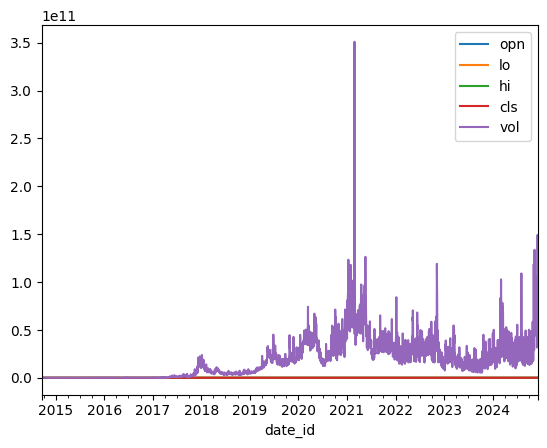

In [8]:
df.plot()